In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
with tf.device('/CPU:0'):
    
##### PHYSICAL PARAMETERS #####
    r_0 , v_0, phi_0, J, Q, dt = 5., -1., 0., 1., 1., 0.0001

##### NN PARAMETERS #####
    epochs, batch_size, learning_rate, n_in, n_1, n_out = 5, 100, 0.1, 1, 16, 2

##### WEIGHTS AND BIASES INITIALIZATION #####
    weights_1 = tf.Variable(tf.random.uniform(shape=(n_1, n_in), minval=0., maxval=2.), dtype=tf.float32)
    weights_out = tf.Variable(tf.random.uniform(shape=(n_out, n_1), minval=0., maxval=2.), dtype=tf.float32)
    bias_1 = tf.Variable(tf.random.uniform(shape=(n_1,1), minval = 0., maxval = 2.), dtype = tf.float32)
    bias_out = tf.Variable(tf.random.uniform(shape=(n_out,1), minval = 0., maxval = 2.), dtype = tf.float32)

#####
    optimizer = tf.keras.optimizers.SGD(learning_rate)

##### SOLUTIONS AS FUNCTIONS OF NN #####
    def sol(x):
        return [(nn(x)[0]-nn(0.)[0]+v_0)*x+r_0, nn(x)[1]*x+phi_0]

##### SOURCES (RHS) #####
    def source(x):
        return [(Q**2+J**2+2.*Q**2*J**2/sol(x)[0]**2)/(sol(x)[0]**3)*dt**2, 2.*J*dt/(sol(x)[0]**2)]

#####EQUATIONS OF MOTION (LHS) #####
    def dx_dt(tau):
        return [sol(tau+dt)[0]-2.*sol(tau)[0]+sol(tau-dt)[0], (sol(tau+dt)[1]-sol(tau-dt)[1])]

##### LOSS FUNCTION #####
    def loss(t):
        loss_sum = 0.0
        for tau in t:
            dnn = dx_dt(tau)
            f_val = source(tau)
            loss_sum += (dnn[0] - f_val[0])**2+(dnn[1] - f_val[1])**2
        return loss_sum

##### NN #####
    def nn(x):
        p = tf.constant([[x] for i in range(n_in)], dtype='float32')
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(weights_1, p), bias_1))
        layer_out = tf.add(tf.matmul(weights_out, layer_1), bias_out)
        return layer_out

##### TRAINING #####
    def train_step():
        start=time.time()
        with tf.GradientTape() as tape:
            loss_value= loss(t)
        gradients = tape.gradient(loss_value, [weights_1,  weights_out, bias_1,  bias_out])
        optimizer.apply_gradients(zip(gradients, [weights_1,  weights_out, bias_1,  bias_out]))
        return loss_value

    for i in range(epochs):
        t = np.random.uniform(0., 1., batch_size).astype(np.float32)
        loss_value = train_step()
        print("Loss:", loss_value.numpy())

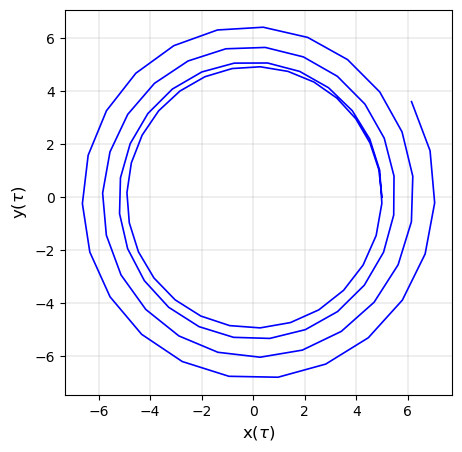

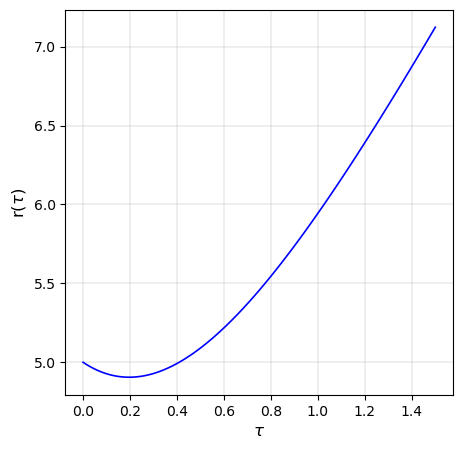

In [2]:
##### PLOT #####
t = np.linspace(0., 1.5, batch_size)
def fx(t):
    return sol(t)[0].numpy()[0]*np.cos(sol(t)[1].numpy()[0])
def fy(t):
    return sol(t)[0].numpy()[0]*np.sin(sol(t)[1].numpy()[0])
def fr(t):
    return sol(t)[0].numpy()[0]

x_val = [fx(i) for i in t]
y_val = [fy(i) for i in t]
r_val = [fr(i) for i in t]

plt.figure(figsize=(5, 5))
plt.plot(x_val, y_val, color='blue', linewidth=1.2)
plt.xlabel('x($\\tau$)', fontsize=12)
plt.ylabel('y($\\tau$)', fontsize=12)
plt.grid(linewidth=0.3)
plt.savefig('grafico_xy.png',dpi=300)
plt.show()

# Secondo plot
plt.figure(figsize=(5, 5))
plt.plot(t, r_val, color='blue', linewidth=1.2)
plt.xlabel('$\\tau$', fontsize=12)
plt.ylabel('r($\\tau$)', fontsize=12)
plt.grid(linewidth=0.3)
plt.savefig('grafico_r.png',dpi=300)
plt.show()